In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import os
import sys

module_path = os.path.abspath(os.path.join(os.getcwd(), "../src"))
if module_path not in sys.path:
    sys.path.append(module_path)

from maze_env import MazeEnv
from maze import Maze
from maze_env import dist_to_wall_exact
from maze_env import compute_dead_end_mask
from maze_env import compute_horizontal_corridor_mask
from maze_env import compute_degree_matrix
from collections import deque

# Initialization of env.
maze = Maze(10, 10, 0, 0) 
env = MazeEnv(sz=10, maze=None, start=np.array([0.05, 0.05]), goal=np.array([0.95, 0.95]),
               reward="distance", log=False, eval=False, dt=0.1, horizon=100, 
               wall_penalty=10, slide=1, image_freq=100)

dead_mask = compute_dead_end_mask(
    env.maze, 
    exits={(
        int(env.goal[0]*env.sz), 
        int(env.goal[1]*env.sz)
        )})

corr_mask = compute_horizontal_corridor_mask(env.maze)

deg_mat = compute_degree_matrix(env.maze)

def generate_positions_balanced(env, num_samples=5000, target_ratio=0.5):
    """
    target_ratio = frazione desiderata di punti con degree>0
    """
    points_zero, points_nonzero = [], []
    # rigenera finché non hai il mix desiderato
    while len(points_zero) + len(points_nonzero) < num_samples:
        s = env.sample_open_state_continuous()
        # deg = corridor_degree(env, *s)              # la nuova funzione
        deg = corridor_degree_continuous(env, *s)
        (points_nonzero if deg > 0 else points_zero).append(tuple(s))
        # stop se abbiamo raggiunto il rapporto
        nz_needed = int(num_samples * target_ratio)
        z_needed  = num_samples - nz_needed
        if len(points_nonzero) >= nz_needed and len(points_zero) >= z_needed:
            break
    # ritaglia e mescola
    points = points_nonzero[:nz_needed] + points_zero[:z_needed]
    random.shuffle(points)
    return np.array(points, dtype=float)

# Extended dead-end detection function
def is_dead_end_extended(env, x, y, radius=2):
    cx, cy = int(x * env.sz), int(y * env.sz)
    blocked_directions = 0
    
    for dx in range(-radius, radius + 1):
        for dy in range(-radius, radius + 1):
            nx, ny = cx + dx, cy + dy
            if nx < 0 or nx >= env.maze.nx or ny < 0 or ny >= env.maze.ny:
                blocked_directions += 1
            else:
                cell = env.maze.cell_at(nx, ny)
                if all(cell.walls.values()):
                    blocked_directions += 1
    
    return blocked_directions >= (radius * radius // 2)


import numpy as np
from scipy.spatial import distance
from queue import PriorityQueue

def can_move(env, cx, cy, nx, ny):
    """
    Verifica se è possibile muoversi dalla cella (cx,cy) alla cella (nx,ny)
    controllando sia i limiti che i muri parziali.
    """
    # Se la cella di destinazione è fuori indice o completamente chiusa, non si può entrare
    if nx < 0 or nx >= env.maze.nx or ny < 0 or ny >= env.maze.ny:
        return False
    if all(env.maze.cell_at(nx, ny).walls.values()):
        return False
    
    # Controlliamo i muri fra cella corrente e cella destinazione
    current_cell = env.maze.cell_at(cx, cy)
    next_cell    = env.maze.cell_at(nx, ny)
    dx = nx - cx
    dy = ny - cy

    # Muoversi a nord => dy=-1
    if dx == 0 and dy == -1:
        if current_cell.walls["N"] or next_cell.walls["S"]:
            return False
    # Muoversi a sud => dy=+1
    elif dx == 0 and dy == 1:
        if current_cell.walls["S"] or next_cell.walls["N"]:
            return False
    # Muoversi a est => dx=+1
    elif dx == 1 and dy == 0:
        if current_cell.walls["E"] or next_cell.walls["W"]:
            return False
    # Muoversi a ovest => dx=-1
    elif dx == -1 and dy == 0:
        if current_cell.walls["W"] or next_cell.walls["E"]:
            return False

    return True


def shortest_path_distance(env, x, y):
    """
    Esegue una ricerca di cammino minimo (tipo A*) dal punto (x,y) continuo 
    (in [0,1]^2) alla cella che contiene il goal env.goal,
    restituendo il costo (in celle attraversate) oppure np.inf se non esiste un percorso.
    """
    # Convertiamo le coordinate da [0..1] a celle
    cx, cy = int(x * env.sz), int(y * env.sz)
    goal_x, goal_y = int(env.goal[0] * env.sz), int(env.goal[1] * env.sz)
    
    frontier = PriorityQueue()
    frontier.put((0, (cx, cy)))         # coda prioritaria (costo stimato, (cx,cy))
    cost_so_far = {(cx, cy): 0}         # dizionario dei costi finora noti

    while not frontier.empty():
        _, current = frontier.get()     # estrai la cella con priorità minore
        if current == (goal_x, goal_y):
            # Abbiamo trovato il goal
            break

        current_cost = cost_so_far[current]
        
        # Proviamo tutte le direzioni (N, S, E, W)
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nx, ny = current[0] + dx, current[1] + dy
            
            # Verifica i muri
            if not can_move(env, current[0], current[1], nx, ny):
                continue
            
            new_cost = current_cost + 1
            # Se non abbiamo mai visitato next_pos o se abbiamo trovato un costo minore, aggiorna
            if (nx, ny) not in cost_so_far or new_cost < cost_so_far[(nx, ny)]:
                cost_so_far[(nx, ny)] = new_cost
                # euristica: distanza euclidea dalla destinazione
                priority = new_cost + distance.euclidean((nx, ny), (goal_x, goal_y))
                frontier.put((priority, (nx, ny)))
    
    # Se non è stato trovato un percorso, restituisce np.inf
    return cost_so_far.get((goal_x, goal_y), np.inf)


def is_dead_end(env, x, y, dead_mask):
    cx = min(int(x * env.sz), env.maze.nx - 1)
    cy = min(int(y * env.sz), env.maze.ny - 1)
    return dead_mask[cy, cx]

def in_horizontal_corridor(env, x, y, corr_mask):
    cx = min(int(x * env.sz), env.maze.nx-1)
    cy = min(int(y * env.sz), env.maze.ny-1)
    return bool(corr_mask[cy, cx])

def cell_degree(env, x, y, deg_mat):
    cx = min(int(x*env.sz), env.maze.nx-1)
    cy = min(int(y*env.sz), env.maze.ny-1)
    return int(deg_mat[cy, cx])


# ------------------------------------------------------------------
# corridor_degree_continuous
# ------------------------------------------------------------------
from collections import deque
import numpy as np

# maze_env.py  (sostituisci la vecchia versione)
def _build_corridor_maps(env):
    """
    Calcola le distanze in passi di cella dallo start e dal *vero* goal
    e la lunghezza ottimale del percorso.  Restituisce d_start, d_goal, path_len.
    """
    nx, ny = env.maze.nx, env.maze.ny
    start_cell = (0, 0)                               # fissi: serpentina parte qui

    # goal dinamico in base a env.goal
    gx = min(int(env.goal[0] * env.sz), nx - 1)
    gy = min(int(env.goal[1] * env.sz), ny - 1)
    goal_cell = (gx, gy)

    def bfs(root):
        dist = np.full((ny, nx), np.inf, dtype=float)
        Q = deque([root])
        dist[root[1], root[0]] = 0
        while Q:
            cx, cy = Q.popleft()
            for dx, dy, w_cur, w_nxt in [(-1,0,'W','E'),(1,0,'E','W'),
                                         (0,-1,'N','S'),(0,1,'S','N')]:
                nx_, ny_ = cx+dx, cy+dy
                if nx_ < 0 or nx_ >= nx or ny_ < 0 or ny_ >= ny:
                    continue
                c, n = env.maze.cell_at(cx, cy), env.maze.cell_at(nx_, ny_)
                if c.walls[w_cur] or n.walls[w_nxt]:
                    continue
                if dist[ny_, nx_] == np.inf:
                    dist[ny_, nx_] = dist[cy, cx] + 1
                    Q.append((nx_, ny_))
        return dist

    d_start = bfs(start_cell)
    d_goal  = bfs(goal_cell)
    path_len = d_start[goal_cell[1], goal_cell[0]]     # ∞ se irraggiungibile
    return d_start, d_goal, path_len



def corridor_degree_continuous(env, x, y):
    """
    • 0 su corridoi ciechi o celle irraggiungibili / fuori percorso
    • [0,1] lungo il percorso serpentina dallo start (0) al goal (1)
    """
    # -------------------------------------------------------------
    # 1) inizializza le mappe la prima volta e memorizza in env
    # -------------------------------------------------------------
    if not hasattr(env, "_corr_maps"):
        env._corr_maps = _build_corridor_maps(env)     # tuple

    d_start, d_goal, path_len = env._corr_maps

    if np.isinf(path_len):                             # caso “labirinto rotto”
        return 0.0

    # -------------------------------------------------------------
    # 2) da continuo (x,y) → indici di cella (cx,cy)
    # -------------------------------------------------------------
    cx = min(int(x * env.sz), env.maze.nx - 1)
    cy = min(int(y * env.sz), env.maze.ny - 1)

    ds = d_start[cy, cx]
    dg = d_goal[cy, cx]

    # -------------------------------------------------------------
    # 3) fuori dal percorso “buono”  →  grado 0
    #    (tolleranza 1e‑6 per arrotondamenti)
    # -------------------------------------------------------------
    if np.isinf(ds) or np.isinf(dg) or abs((ds + dg) - path_len) > 1e-6:
        return 0.0

    # -------------------------------------------------------------
    # 4) cella sul percorso: normalizza in [0,1]
    # -------------------------------------------------------------
    return float(ds / path_len)


# Function to calculate the score points 
def compute_scores(env, positions):
    scores = []
    goal = np.array(env.goal)
    
    for pos in positions:
        x, y = pos
        
        distance_to_goal = np.linalg.norm(goal - np.array([x, y]))

        distance_from_wall = dist_to_wall_exact(env, x, y)
        
        # degree = cell_degree(env, x, y, deg_mat)
        # degree = corridor_degree(env, x, y)
        degree = corridor_degree_continuous(env, x, y)
        
        # Shortest path distance
        path_distance = shortest_path_distance(env, x, y)
        
        scores.append((x, y, distance_to_goal, distance_from_wall, degree, path_distance))
    
    return scores

def generate_corridor_points(env, n_per_row=600):
    """Restituisce punti equispaziati all’interno delle righe aperte (y = 0,3,6,9 …)."""
    pts = []
    for row in range(0, env.maze.ny, 3):          # step=3 nella make_maze_fail
        y_c = (row + 0.5) / env.sz                # centro riga
        xs   = np.linspace(0.05, 0.95, n_per_row)
        pts += [(x, y_c) for x in xs
                 if not env.point_collision(x, y_c)]
    return np.asarray(pts, dtype=float)

# Generate the points 
points_to_generate_randomly = 4000
# positions = generate_positions(env, num_samples=points_to_generate, max_attempts=10*points_to_generate)
points_random = generate_positions_balanced(env, num_samples=points_to_generate_randomly, target_ratio=0.5)

point_to_generate_corridor = 20
points_corridor = generate_corridor_points  (env, n_per_row=point_to_generate_corridor)

extra = []
for _ in range(50):
    x = np.random.uniform(0.90, 0.99)
    y = np.random.uniform(0.90, 0.99)
    extra.append((x, y))

positions = np.vstack([points_random, points_corridor, extra])

# Calculate the scores per each point 
scores = compute_scores(env, positions)

# Save points and scores 
df_positions = pd.DataFrame(scores, columns=["x", "y", "distance_to_goal", "distance_from_wall", "degree", "path_distance"])

df_positions['distance_to_goal'] = df_positions['distance_to_goal']/df_positions['distance_to_goal'].max()
df_positions['distance_from_wall'] = df_positions['distance_from_wall']/df_positions['distance_from_wall'].max()
df_positions['degree'] = df_positions['degree']/df_positions['degree'].max()
df_positions['path_distance'] = df_positions['path_distance']/df_positions['path_distance'].max()
# --- distanza dal varco verticale (normalizzata 0..1) ---
#   lato varco = nx-1 quando si va a destra, 0 quando si va a sinistra
varco_col = df_positions["y"].mul(env.sz).floordiv(3)    # blocco di 3 righe
direction = (varco_col % 2 == 0)                         # True => si va a dx
col_varco = np.where(direction, 1.0, 0.0)                # 1 (dx) o 0 (sx) in coord. normalizzate
df_positions["distance_to_gate"] = np.abs(df_positions["x"] - col_varco)
df_positions["distance_to_gate"] /= df_positions["distance_to_gate"].max()  # 0..1

df_positions.to_parquet("positions.parquet", index=False)


Creating Path with step 3


In [10]:
# In generate_dataset.py, dopo aver creato df_positions[["x", "y"]]
all_xy_positions = df_positions[["x", "y"]].values
mean_val = np.mean(all_xy_positions, axis=0)
std_val = np.std(all_xy_positions, axis=0)
np.savez("norm_stats.npz", mean=mean_val, std=std_val)
print(f"Salvate statistiche di normalizzazione: media={mean_val}, std={std_val}")

Salvate statistiche di normalizzazione: media=[0.51137009 0.50037308], std=[0.29466002 0.29563818]


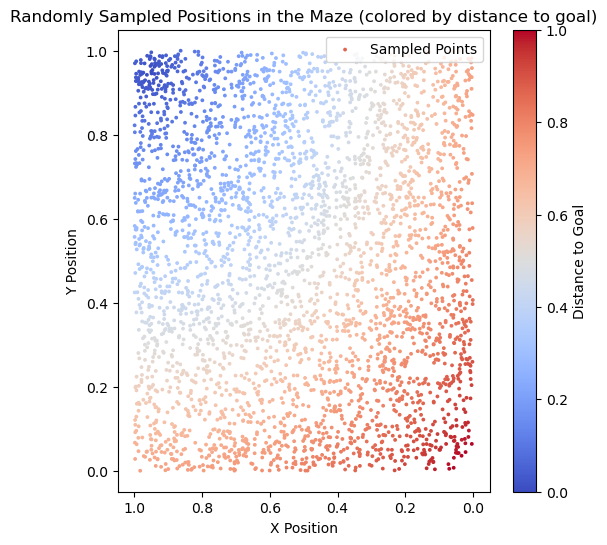

In [11]:
# Nice plot 
plt.figure(figsize=(6,6))
plt.scatter(df_positions["x"], df_positions["y"], c=df_positions["distance_to_goal"], cmap="coolwarm", s=3, label="Sampled Points")
plt.gca().invert_xaxis()
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Randomly Sampled Positions in the Maze (colored by distance to goal)")
plt.colorbar(label="Distance to Goal")
plt.show()

/var/folders/93/qz6yv96d61jg9b5h0sp47v_00000gn/T/ipykernel_59900/322153674.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


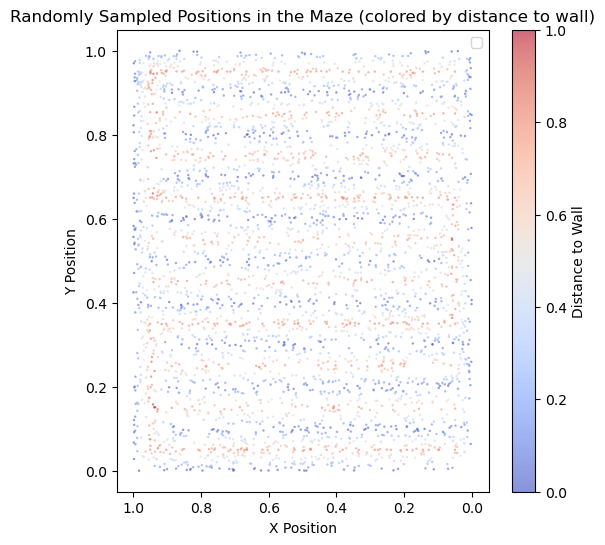

In [12]:
# Nice plot 
plt.figure(figsize=(6,6))

plt.scatter(df_positions["x"], df_positions["y"],
            c=df_positions["distance_from_wall"],
            cmap="coolwarm", s=3, linewidths=0, alpha=0.6,
            vmin=0, vmax=1)          # 0-12 cm sono quelli veramente vicini al muro

plt.gca().invert_xaxis()
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Randomly Sampled Positions in the Maze (colored by distance to wall)")
plt.colorbar(label="Distance to Wall")
plt.show()

/var/folders/93/qz6yv96d61jg9b5h0sp47v_00000gn/T/ipykernel_59900/2858609734.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


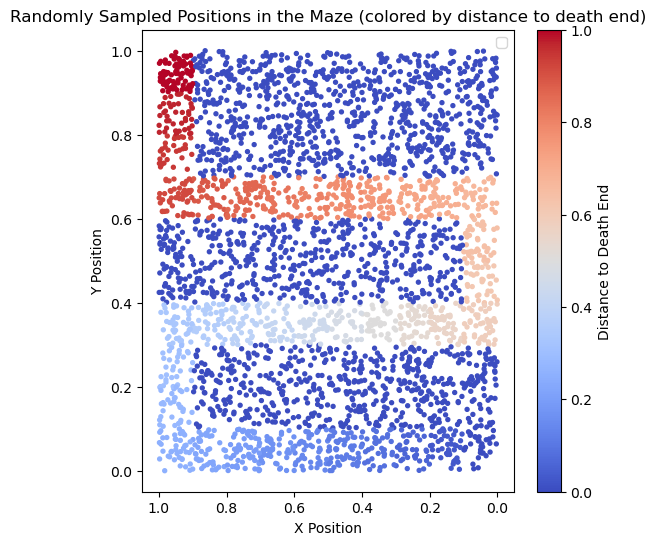

In [13]:
# Nice plot 
plt.figure(figsize=(6,6))
# plt.scatter(df_positions["x"], df_positions["y"], c=df_positions["is_dead_end"], cmap="coolwarm", s=10, label="Sampled Points")
plt.scatter(df_positions["x"], df_positions["y"],
            c=df_positions["degree"],
            cmap="coolwarm", vmin=0, vmax=1, s=8)
plt.gca().invert_xaxis()
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Randomly Sampled Positions in the Maze (colored by distance to death end)")
plt.colorbar(label="Distance to Death End")
plt.show()

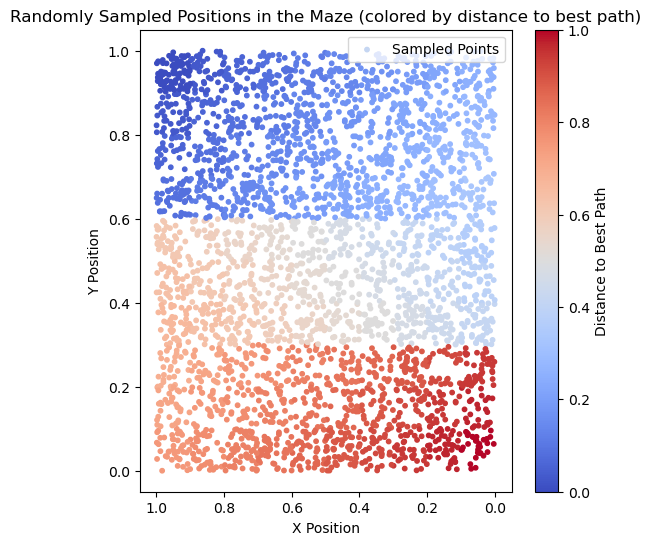

In [14]:
# Nice plot 
plt.figure(figsize=(6,6))
plt.scatter(df_positions["x"], df_positions["y"], c=df_positions["path_distance"], cmap="coolwarm", s=10, label="Sampled Points")
plt.gca().invert_xaxis()
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Randomly Sampled Positions in the Maze (colored by distance to best path)")
plt.colorbar(label="Distance to Best Path")
plt.show()

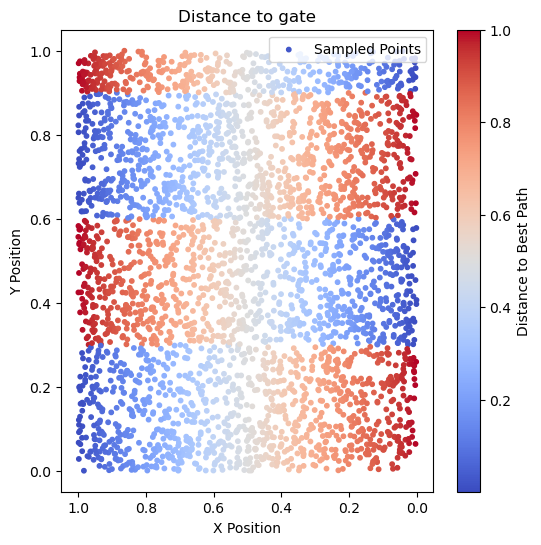

In [15]:
plt.figure(figsize=(6,6))
plt.scatter(df_positions["x"], df_positions["y"], c=df_positions["distance_to_gate"], cmap="coolwarm", s=10, label="Sampled Points")
plt.gca().invert_xaxis()
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Distance to gate")
plt.colorbar(label="Distance to Best Path")
plt.show()

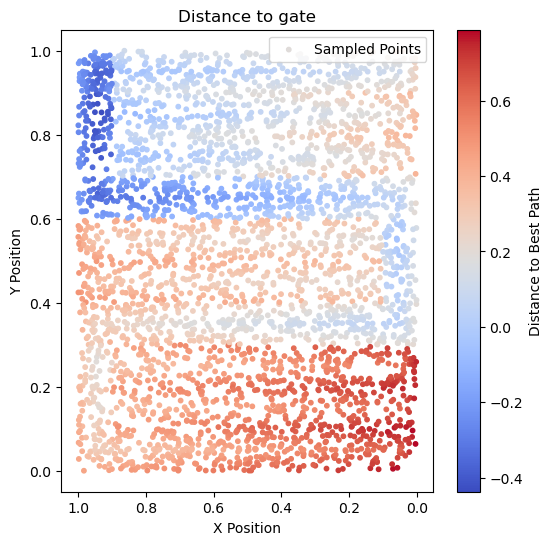

In [16]:
w_path, w_wall, w_goal, w_deg, w_gate = 0.5, 0.2, 0.2, 0.3, 0.1

# --------------------------------------------------------
# 4) score (minore è migliore)
# --------------------------------------------------------
df_positions["total_score"] = (
      w_path * df_positions.path_distance        #  + penalità: cammino lungo
    + w_goal * df_positions.distance_to_goal        #  + penalità: lontano dal goal
    - w_deg  * df_positions.degree         #  + penalità: vicolo cieco
    - w_wall * df_positions.distance_from_wall        #  – bonus: punti “larghi”, lontani dai muri
    + w_gate * df_positions.distance_to_gate
)

# df_positions["total_score"] = df_positions["total_score"]/df_positions["total_score"].max()

plt.figure(figsize=(6,6))
plt.scatter(df_positions["x"], df_positions["y"], c=df_positions["total_score"], cmap="coolwarm", s=10, label="Sampled Points")
plt.gca().invert_xaxis()
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Distance to gate")
plt.colorbar(label="Distance to Best Path")
plt.show()